# Projet 2 - Fashion Trend Intelligence | Segmentation vestimentaire avec IA

Ce notebook permet d’évaluer la faisabilité technique du modèle SegFormer-clothes, afin de déterminer s’il est capable d’identifier et d’isoler avec précision chaque pièce vestimentaire présente dans une image.


## 1. Installation du projet et de son environnement

Afin d’utiliser correctement ce notebook, vérifiez que vous disposez du bon environnement pour l’exécuter.


### 1.1 Installation de Python

Pour ce projet, il est nécessaire d’avoir **au minimum Python 3.8**.  
Si ce n’est pas déjà le cas, vous pouvez vous référer à [la documentation officielle](https://www.python.org/downloads/).

Vérifiez votre version de Python :

```bash
python --version
```

### 1.2 Installation de `uv`

`uv` est un gestionnaire de projets Python permettant d’installer et d’organiser les dépendances plus rapidement et plus simplement que les outils traditionnels (`pip`, `virtualenv`, etc.).

Pour installer `uv`, veuillez suivre [la documentation officielle](https://docs.astral.sh/uv/getting-started/installation/#standalone-installer)

Vérifiez l’installation :

```bash
uv --version
```

### 1.3 Création du projet

Créez un nouveau projet Python avec `uv` :

```bash
uv init nom_du_projet
cd nom_du_projet
```

La structure de base du projet est alors générée automatiquement.


### 1.4 Création et activation de l’environnement virtuel

Créez l’environnement virtuel :

```bash
uv venv
```

Activez-le selon votre système :

* **Linux / macOS**

```bash
source .venv/bin/activate
```

* **Windows (PowerShell)**

```powershell
.venv\Scripts\Activate.ps1
```

Voir la documentation officielle :
[https://docs.astral.sh/uv/pip/environments/#creating-a-virtual-environment](https://docs.astral.sh/uv/pip/environments/#creating-a-virtual-environment)



### 1.5 Installation des dépendances

> ❗ Assurez-vous que l’environnement virtuel est **activé** avant d’installer les dépendances.

Installez les bibliothèques nécessaires au projet :

```bash
uv add ipykernel jupyterlab requests pillow matplotlib numpy tqdm python-dotenv aiohttp
```

Ces dépendances sont automatiquement enregistrées dans le fichier `pyproject.toml`.

Vous pouvez visualiser l’ensemble des dépendances installées avec la commande suivante :

```bash
uv tree
```

### 1.6 Création du fichier `.env`

Créez un fichier nommé `.env` à la racine du projet.

Copiez-y le contenu suivant et remplacez les valeurs si nécessaire :

```env
# Token d'authentification à l'API Hugging Face
HF_API_TOKEN=VOTRE_TOKEN_HUGGING_FACE_ICI

# Chemins du dataset
DATASET_IMAGES_DIR=content/images_a_segmenter
DATASET_ANNOTATIONS_DIR=content/annotations
```

⚠️ **Important** :

* Ne partagez jamais votre fichier `.env`
* Ajoutez-le à votre `.gitignore`

```gitignore
.env
```

### 1.7 Création d’un token Hugging Face

1. Créez un compte sur [https://huggingface.co/](https://huggingface.co/)
2. Allez dans **Profile → Settings → Access Tokens**
3. Créez un nouveau token (rôle **read** suffisant)
4. Copiez le token dans la variable `HF_API_TOKEN` du fichier `.env`


### 1.8 Préparation des jeux de données

Récupérez les jeux de données (images et annotations) et placez-les dans les dossiers suivants :

```
content/
├── images_a_segmenter/
│   ├── image_0.jpg
│   ├── image_1.jpg
│   └── ...
└── annotations/
    ├── mask_0.json
    ├── mask_1.json
    └── ...
```

## 2. Importation des Bibliothèques

Commençons par importer les bibliothèques Python nécessaires. Nous aurons besoin de :
- **`os`** : Interaction avec le système de fichiers (navigation dans les répertoires, listage des fichiers images).
- **`requests`** : Envoi de requêtes HTTP vers l'API pour la segmentation d'images.
- **`PIL (Pillow)`** : Manipulation et traitement des images (ouverture, redimensionnement, conversion).
- **`matplotlib.pyplot`** : Visualisation des images originales et des masques de segmentation.
- **`matplotlib.patches`** : Création d'éléments graphiques personnalisés pour les légendes des visualisations.
- **`numpy`** : Manipulation efficace des tableaux numériques représentant les pixels des images.
- **`tqdm.notebook`** : Affichage d'une barre de progression interactive dans les notebooks Jupyter (utile lors du traitement par lot).
- **`base64`** : Encodage/décodage en Base64 des images et masques échangés avec l'API.
- **`io`** : Gestion des flux de données en mémoire pour la manipulation des images sans fichiers temporaires.
- **`python-dotenv`** : Chargement sécurisé des variables d'environnement (comme les clés API) depuis un fichier `.env`.
- **`time`** : Gestion des délais entre les appels API pour respecter les limites de taux (rate limiting).
- **`re`** : Traitement d'expressions régulières (parsing de réponses, validation de formats).
- **`aiohttp`** : Requêtes HTTP asynchrones pour améliorer les performances lors du traitement par lot d'images.


In [55]:
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import Colormap
import numpy as np
import numpy.typing as npt
from tqdm.notebook import tqdm
from tqdm.asyncio import tqdm as async_tqdm
import base64
import io
from dotenv import load_dotenv
import time
import re
import asyncio
import aiohttp
from typing import Dict, List, TypedDict, Union, Tuple
from datetime import datetime
from pathlib import Path


## 3. Chargement de la Configuration

In [56]:
# Charger les variables d'environnement depuis le fichier .env
load_dotenv(override=True)

# Récupération des variables d'environnement
IMAGES_DIR = os.getenv('DATASET_IMAGES_DIR')
ANNOTATIONS_DIR = os.getenv('DATASET_ANNOTATIONS_DIR')
API_TOKEN = os.getenv('HF_API_TOKEN')
MAX_IMAGES = 2  # Nombre maximum d'images à traiter

# Vérification de la présence des variables
if not IMAGES_DIR or not API_TOKEN or not ANNOTATIONS_DIR:
    raise ValueError("Variables d'environnement manquantes dans le fichier .env")

# Vérification du token
if API_TOKEN == "VOTRE_TOKEN_HUGGING_FACE_ICI":
    raise ValueError("Vous devez remplacer 'VOTRE_TOKEN_HUGGING_FACE_ICI' par votre token API personnel dans le fichier .env")

# Création des dossiers s'ils n'existent pas
for directory, name in [(IMAGES_DIR, "images"), (ANNOTATIONS_DIR, "annotations")]:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"✓ Dossier '{directory}' créé pour les {name}.")
    else:
        print(f"✓ Dossier '{directory}' existant.")

# Lister les chemins des images à traiter
image_paths = []
for f in os.listdir(IMAGES_DIR):
    if f.endswith(('.png', '.jpg', '.jpeg')):
        image_paths.append(IMAGES_DIR + '/' + f)

if not image_paths:
    print(f"Aucune image trouvée dans '{IMAGES_DIR}'. Veuillez y ajouter des images.")
else:
    print(f"{len(image_paths)} image(s) à traiter : {image_paths}")

# Trier naturellement (image_1, image_2, image_10, etc.)
def natural_sort_key(path):
    filename = os.path.basename(path)
    # Extraire les nombres du nom de fichier
    return [int(text) if text.isdigit() else text.lower() 
            for text in re.split('([0-9]+)', filename)]

image_paths.sort(key=natural_sort_key)

# Limiter le nombre d'images à traiter
image_paths = image_paths[:MAX_IMAGES]
if len(image_paths) < len(os.listdir(IMAGES_DIR)):
    print(f"Limitation appliquée : traitement de {len(image_paths)} image(s) sur {len(os.listdir(IMAGES_DIR))} disponibles")

✓ Dossier 'content/images_a_segmenter' existant.
✓ Dossier 'content/annotations' existant.
50 image(s) à traiter : ['content/images_a_segmenter/image_48.png', 'content/images_a_segmenter/image_33.png', 'content/images_a_segmenter/image_12.png', 'content/images_a_segmenter/image_1.png', 'content/images_a_segmenter/image_18.png', 'content/images_a_segmenter/image_14.png', 'content/images_a_segmenter/image_43.png', 'content/images_a_segmenter/image_36.png', 'content/images_a_segmenter/image_13.png', 'content/images_a_segmenter/image_20.png', 'content/images_a_segmenter/image_25.png', 'content/images_a_segmenter/image_32.png', 'content/images_a_segmenter/image_7.png', 'content/images_a_segmenter/image_15.png', 'content/images_a_segmenter/image_22.png', 'content/images_a_segmenter/image_19.png', 'content/images_a_segmenter/image_24.png', 'content/images_a_segmenter/image_34.png', 'content/images_a_segmenter/image_3.png', 'content/images_a_segmenter/image_41.png', 'content/images_a_segmenter

## 4. Configuration de l'API Hugging Face

### 4.1 Présentation du modèle
Nous utilisons le modèle [**SegFormer-B3-Clothes**](https://huggingface.co/sayeed99/segformer_b3_clothes) qui est spécialisé dans la segmentation sémantique de vêtements. Ce modèle peut détecter 18 classes différentes :
- Éléments vestimentaires : chapeau, haut, jupe, pantalon, robe, ceinture, chaussures, sac, écharpe
- Parties du corps : cheveux, visage, bras, jambes
- Accessoires : lunettes de soleil
- Arrière-plan

### 4.2 Configuration de l'endpoint API
L'API Hugging Face Inference Router permet d'interroger le modèle sans avoir à le déployer localement. Voici les éléments de configuration :

**URL de l'API** : `https://router.huggingface.co/hf-inference/models/sayeed99/segformer_b3_clothes`

**Headers requis** :
- `Authorization: Bearer YOUR_TOKEN` : Authentification avec votre token personnel
- `Content-Type: image/jpeg` ou `image/png` : Type MIME de l'image envoyée

**Format de réponse** : L'API retourne un JSON contenant une liste de masques encodés en base64, un par classe détectée.

**Sécurité** : Ne jamais hardcoder votre token dans le notebook. Elle doit mis dans la variable d'environnement `HF_API_TOKEN'` le fichier `.env`

### 4.3 Bonnes pratiques d'utilisation
1. **Rate Limiting** : Espacer les requêtes de 1-2 secondes pour éviter les erreurs 429 (Too Many Requests)
2. **Timeout** : Définir un timeout de 30 secondes minimum (le modèle peut être lent)
3. **Gestion d'erreurs** : Prévoir les cas suivants :
   - 401 : Token invalide
   - 429 : Trop de requêtes
   - 500 : Erreur serveur (réessayer après quelques secondes)
   - 503 : Modèle en cours de chargement (attendre et réessayer)

In [61]:
API_URL = "https://router.huggingface.co/hf-inference/models/sayeed99/segformer_b3_clothes"
headers = {
    "Authorization": f"Bearer {API_TOKEN}"
    # Le "Content-Type" sera ajouté dynamiquement lors de l'envoi de l'image
}


# Rate limiting pour compte gratuit (d'après la doc HF)
# Inference API : ~1000 requêtes/jour, avec burst de ~100 requêtes/min
REQUESTS_PER_MINUTE = 30  # On reste prudent (bien en dessous de 100)
DELAY_BETWEEN_REQUESTS = 60 / REQUESTS_PER_MINUTE  # ~2 secondes entre chaque requête


# Configuration des requêtes asynchrones
MAX_CONCURRENT_REQUESTS = 5      # Nombre de requêtes simultanées maximum
MAX_RETRIES = 3                  # Nombre de tentatives en cas d'erreur
INITIAL_RETRY_DELAY = 2          # Délai initial entre les tentatives (secondes)
REQUEST_TIMEOUT = 30             # Timeout des requêtes (secondes)

CLASS_MAPPING = {
    "Background": 0,
    "Hat": 1,
    "Hair": 2,
    "Sunglasses": 3,
    "Upper-clothes": 4,
    "Skirt": 5,
    "Pants": 6,
    "Dress": 7,
    "Belt": 8,
    "Left-shoe": 9,
    "Right-shoe": 10,
    "Face": 11,
    "Left-leg": 12,
    "Right-leg": 13,
    "Left-arm": 14,
    "Right-arm": 15,
    "Bag": 16,
    "Scarf": 17
}

def get_image_dimensions(img_path):
    """
    Get the dimensions of an image.

    Args:
        img_path (str): Path to the image.

    Returns:
        tuple: (width, height) of the image.
    """
    original_image = Image.open(img_path)
    return original_image.size

def decode_base64_mask(base64_string, width, height):
    """
    Decode a base64-encoded mask into a NumPy array.

    Args:
        base64_string (str): Base64-encoded mask.
        width (int): Target width.
        height (int): Target height.

    Returns:
        np.ndarray: Single-channel mask array.
    """
    mask_data = base64.b64decode(base64_string)
    mask_image = Image.open(io.BytesIO(mask_data))
    mask_array = np.array(mask_image)
    if len(mask_array.shape) == 3:
        mask_array = mask_array[:, :, 0]  # Take first channel if RGB
    mask_image = Image.fromarray(mask_array).resize((width, height), Image.NEAREST)
    return np.array(mask_image)

def create_masks(results, width, height):
    """
    Combine multiple class masks into a single segmentation mask.

    Args:
        results (list): List of dictionaries with 'label' and 'mask' keys.
        width (int): Target width.
        height (int): Target height.

    Returns:
        np.ndarray: Combined segmentation mask with class indices.
    """
    combined_mask = np.zeros((height, width), dtype=np.uint8)  # Initialize with Background (0)

    # Process non-Background masks first
    for result in results:
        label = result['label']
        class_id = CLASS_MAPPING.get(label, 0)
        if class_id == 0:  # Skip Background
            continue
        mask_array = decode_base64_mask(result['mask'], width, height)
        combined_mask[mask_array > 0] = class_id

    # Process Background last to ensure it doesn't overwrite other classes unnecessarily
    # (Though the model usually provides non-overlapping masks for distinct classes other than background)
    for result in results:
        if result['label'] == 'Background':
            mask_array = decode_base64_mask(result['mask'], width, height)
            # Apply background only where no other class has been assigned yet
            # This logic might need adjustment based on how the model defines 'Background'
            # For this model, it seems safer to just let non-background overwrite it first.
            # A simple application like this should be fine: if Background mask says pixel is BG, set it to 0.
            # However, a more robust way might be to only set to background if combined_mask is still 0 (initial value)
            combined_mask[mask_array > 0] = 0 # Class ID for Background is 0

    return combined_mask

async def segment_clothes_async(
    session: aiohttp.ClientSession,
    single_image_path: str,
    semaphore: asyncio.Semaphore
) -> Dict:
    """
    Requête asynchrone à l'API Hugging Face avec rate limiting.

    Args:
        session: Session aiohttp partagée
        single_image_path: Chemin vers l'image à segmenter
        semaphore: Sémaphore pour limiter les requêtes concurrentes

    Returns:
        dict: Résultats de la segmentation (JSON de l'API)
        
    Raises:
        FileNotFoundError: Si le fichier image n'existe pas
        ValueError: Si le format d'image n'est pas supporté
        aiohttp.ClientError: Si la requête API échoue
    """
    
    # Vérification de l'existence du fichier
    if not os.path.exists(single_image_path):
        raise FileNotFoundError(f"L'image '{single_image_path}' n'existe pas")
    
    # Vérification du format d'image
    try:
        with Image.open(single_image_path) as img:
            image_format = img.format
            
            if image_format not in ['JPEG', 'PNG']:
                raise ValueError(
                    f"Format '{image_format}' non supporté. "
                    f"Formats acceptés: JPEG, PNG"
                )
    except Exception as e:
        raise ValueError(f"Impossible d'ouvrir l'image: {e}")
    
    # Lecture du contenu binaire
    try:
        with open(single_image_path, 'rb') as fichier:
            image_data = fichier.read()
    except IOError as e:
        raise IOError(f"Erreur lors de la lecture du fichier: {e}")
    
    # Configuration des headers
    request_headers = headers.copy()
    request_headers["Content-Type"] = f"image/{image_format.lower()}"
    
    # Utilisation du sémaphore pour limiter les requêtes concurrentes
    async with semaphore:
        retry_delay = INITIAL_RETRY_DELAY
        
        for attempt in range(MAX_RETRIES):
            try:
                async with session.post(
                    API_URL,
                    headers=request_headers,
                    data=image_data,
                    timeout=aiohttp.ClientTimeout(total=REQUEST_TIMEOUT)
                ) as response:
                    
                    # Gestion des différents codes de statut
                    if response.status == 503:
                        # Modèle en cours de chargement
                        print(f"⏳ Modèle en chargement, attente {INITIAL_RETRY_DELAY}s...")
                        await asyncio.sleep(INITIAL_RETRY_DELAY)
                        retry_delay *= 2  # Backoff exponentiel
                        continue
                    
                    elif response.status == 429:
                        # Rate limit atteint
                        retry_after = response.headers.get('Retry-After', retry_delay)
                        wait_time = int(retry_after) if isinstance(retry_after, str) and retry_after.isdigit() else retry_delay
                        print(f"⚠️ Rate limit atteint, attente {wait_time}s...")
                        await asyncio.sleep(wait_time)
                        continue
                    
                    elif response.status == 401:
                        raise ValueError("Token API invalide ou expiré")
                    
                    elif response.status >= 500:
                        # Erreur serveur, on réessaie
                        if attempt < MAX_RETRIES - 1:
                            print(f"❌ Erreur serveur (5xx), nouvelle tentative dans {retry_delay}s...")
                            await asyncio.sleep(retry_delay)
                            retry_delay *= 2
                            continue
                        else:
                            raise aiohttp.ClientError(
                                f"Erreur serveur persistante (status {response.status})"
                            )
                    
                    # Vérification du statut
                    response.raise_for_status()
                    
                    # Parsing de la réponse
                    results = await response.json()
                    print(f"✅ Réponse reçue pour {os.path.basename(single_image_path)}")
                    
                    # Délai entre les requêtes pour respecter le rate limit
                    await asyncio.sleep(DELAY_BETWEEN_REQUESTS)
                    
                    return results
                    
            except asyncio.TimeoutError:
                if attempt < MAX_RETRIES - 1:
                    print(f"⏱️ Timeout, nouvelle tentative...")
                    await asyncio.sleep(retry_delay)
                    continue
                else:
                    raise asyncio.TimeoutError(
                        f"Timeout après {MAX_RETRIES} tentatives pour '{single_image_path}'"
                    )
            
            except aiohttp.ClientError as e:
                if attempt < MAX_RETRIES - 1:
                    print(f"❌ Erreur réseau, nouvelle tentative dans {retry_delay}s...")
                    await asyncio.sleep(retry_delay)
                    continue
                else:
                    raise
        
        raise Exception(f"Échec après {MAX_RETRIES} tentatives")


async def segment_clothes_batch(image_paths: List[str]) -> List[Dict]:
    """
    Segmente un lot d'images de manière asynchrone avec rate limiting.
    
    Args:
        image_paths: Liste des chemins d'images à traiter
        
    Returns:
        List[Dict]: Liste des résultats de segmentation
    """
    # Sémaphore pour limiter les requêtes concurrentes
    semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)
    
    async with aiohttp.ClientSession() as session:
        tasks = [
            segment_clothes_async(session, img_path, semaphore)
            for img_path in image_paths
        ]
        
        # Exécution de toutes les tâches
        results = await async_tqdm.gather(*tasks, desc="Segmentation")        
        
        # Traitement des résultats et des erreurs
        processed_results = []
        for i, result in enumerate(results):
            if isinstance(result, Exception):
                print(f"❌ Erreur pour {image_paths[i]}: {result}")
                processed_results.append(None)
            else:
                width, height = get_image_dimensions(image_paths[i])
                processed_results.append(create_masks(result, width, height))
        
        return processed_results

## 5. Visualisation des annotations (Ground Truth)

Ces annotations serviront de référence pour évaluer la qualité des prédictions du modèle dans les sections suivantes.


[1/2] Traitement de: content/images_a_segmenter/image_0.png
ℹ️  INFORMATIONS:
   - Dimensions: (400, 600)
   - Nombre de classes présentes: 11
   - Classes détectées: [0, 2, 4, 6, 9, 10, 11, 12, 13, 15, 16]


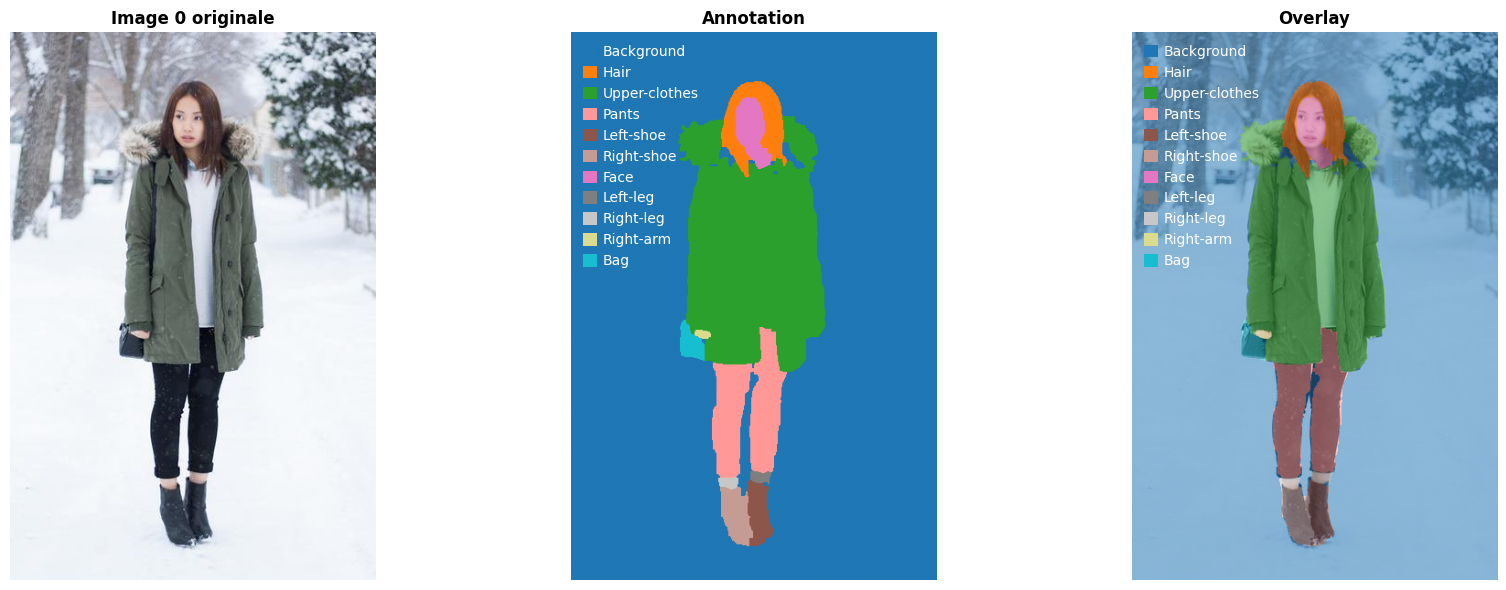


[2/2] Traitement de: content/images_a_segmenter/image_1.png
ℹ️  INFORMATIONS:
   - Dimensions: (400, 600)
   - Nombre de classes présentes: 10
   - Classes détectées: [0, 1, 2, 4, 5, 6, 9, 10, 11, 16]


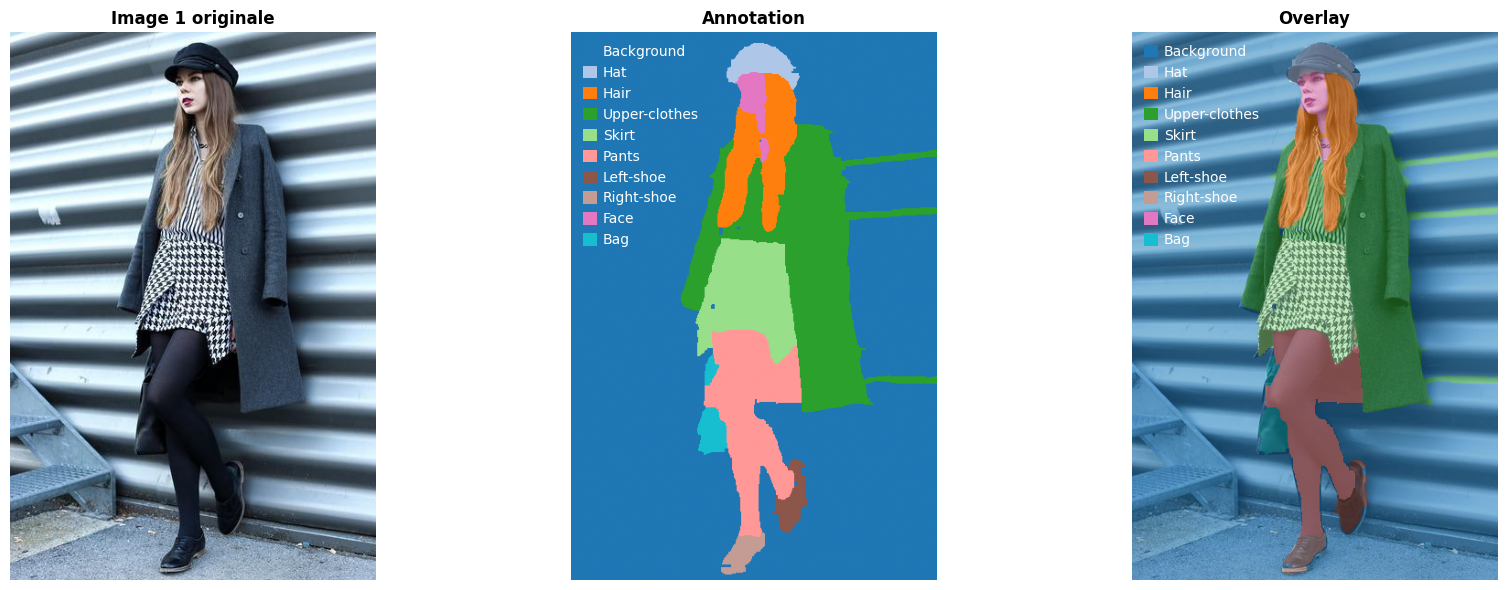


📊 RÉSUMÉ DE LA VÉRIFICATION:
  • Total d'images: 2
  • Images affichées: 2
  • Images avec warnings: 0
  • Images manquantes: 0
  • Masques manquants: 0
  • Erreurs de traitement: 0


In [62]:
# Identifiant de la classe background
BACKGROUND_CLASS_ID = 0

# Configuration de la légende
LEGEND_CONFIG = {
    'loc': 'upper left',
    'frameon': False,
    'handlelength': 1,
    'handleheight': 1,
    'handletextpad': 0.4,
    'labelcolor': 'white',
}

# Configuration de la figure
FIGURE_WIDTH = 18
FIGURE_HEIGHT = 6
OVERLAY_ALPHA = 0.5

# Nom de la colormap
COLORMAP_NAME = 'tab20'

# Préfixes pour les fichiers
MASK_PREFIX = "mask_"
IMAGE_FILENAME_SEPARATOR = '_'
IMAGE_NUMBER_INDEX = 1

# Type alias pour améliorer la lisibilité
PathLike = Union[Path, str]


class ImageInfo(TypedDict):
    """Informations détaillées sur l'image."""
    image_size: Tuple[int, int]
    image_mode: str
    mask_size: Tuple[int, int]
    unique_classes: List[int]
    num_classes: int
    class_distribution: Dict[int, int]

class VerificationResult(TypedDict):
    """Résultat de la vérification d'une paire image/masque."""
    warnings: List[str]
    info: ImageInfo

def get_legend_elements(
    mask_array: npt.NDArray[np.int32],
    id_to_class: Dict[int, str],
    color_map: Colormap,
    num_classes: int
) -> List[Patch]:
    """
    Crée les éléments de légende pour les classes présentes dans le masque.
    
    Args:
        mask_array: Tableau 2D représentant le masque de segmentation
        id_to_class: Mapping {id_classe: nom_classe}
        color_map: Colormap matplotlib
        num_classes: Nombre total de classes
    
    Returns:
        Liste d'objets Patch pour la légende matplotlib
    """
    unique_classes = np.unique(mask_array)
    legend_elements = []
    
    for class_id in unique_classes:
        if class_id in id_to_class:
            # Normalisation pour la colormap [0, 1]
            normalized_id = class_id / (num_classes - 1)
            color = color_map(normalized_id)
            legend_elements.append(
                Patch(facecolor=color, label=id_to_class[class_id])
            )
    
    return legend_elements


def verify_image_mask_pair(
    original_image: Image.Image,
    mask_image: Image.Image,
    max_class_id: int
) -> VerificationResult:
    """
    Vérifie la validité et la cohérence d'une paire image/masque.
    
    Args:
        original_image: Image originale
        mask_image: Masque d'annotation correspondant
        max_class_id: ID de classe maximum attendu

    Returns:
        Résultats de la vérification avec clés 'warnings', 'info'
    """
    result = {
        'warnings': [],
        'info': {}
    }
    
    # Vérifier les dimensions
    if original_image.size != mask_image.size:
        result['warnings'].append(
            f"Dimensions différentes - Image: {original_image.size}, "
            f"Masque: {mask_image.size}"
        )
    
    # Vérifier le mode de l'image
    valid_image_modes = ['RGB', 'RGBA', 'L']
    if original_image.mode not in valid_image_modes:
        result['warnings'].append(f"Mode d'image inhabituel: {original_image.mode}")

    # Analyser le masque
    mask_array = np.array(mask_image)
    unique_classes = np.unique(mask_array)
    
    # Vérifier les valeurs des classes
    invalid_classes = [c for c in unique_classes if c > max_class_id]
    if invalid_classes:
        result['warnings'].append(
            f"Classes invalides détectées: {invalid_classes} "
            f"(max attendu: {max_class_id})"
        )
    
    # Vérifier si le masque est vide (que du background)
    if len(unique_classes) == 1 and unique_classes[0] == BACKGROUND_CLASS_ID:
        result['warnings'].append("Masque vide (que du background)")
    
    # Informations supplémentaires
    result['info'] = {
        'image_size': original_image.size,
        'image_mode': original_image.mode,
        'mask_size': mask_image.size,
        'unique_classes': unique_classes.tolist(),
        'num_classes': len(unique_classes),
        'class_distribution': {
            int(class_id): int(np.sum(mask_array == class_id)) 
            for class_id in unique_classes
        }
    }
    
    return result

def create_visualization_figure(
    original_image: Image.Image,
    mask_image: Image.Image,
    image_number: str,
    mask_array: npt.NDArray[np.int32],
    id_to_class: Dict[int, str],
    color_map: Colormap,
    num_classes: int
) -> None:
    """
    Crée et affiche une figure de visualisation avec 3 subplots.
    
    Args:
        original_image: Image originale
        mask_image: Masque d'annotation
        image_number: Numéro de l'image pour le titre
        mask_array: Tableau numpy du masque pour la légende
        id_to_class: Mapping {id_classe: nom_classe}
        color_map: Colormap matplotlib
        num_classes: Nombre total de classes
    """
    fig, axes = plt.subplots(1, 3, figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

    # Image originale
    axes[0].imshow(original_image)
    axes[0].set_title(f"Image {image_number} originale", fontsize=12, fontweight='bold')
    axes[0].axis("off")
    
    # Masque d'annotation
    axes[1].imshow(
        mask_image,
        cmap=color_map,
        vmin=0,
        vmax=num_classes - 1
    )
    axes[1].set_title("Annotation", fontsize=12, fontweight='bold')
    axes[1].axis("off")
    
    # Overlay (image + masque transparent)
    axes[2].imshow(original_image)
    axes[2].imshow(
        mask_image,
        cmap=color_map,
        alpha=OVERLAY_ALPHA,
        vmin=0,
        vmax=num_classes - 1
    )
    axes[2].set_title("Overlay", fontsize=12, fontweight='bold')
    axes[2].axis("off")
    
    # Ajouter les légendes
    legend_elements = get_legend_elements(mask_array, id_to_class, color_map, num_classes)
    axes[1].legend(handles=legend_elements, **LEGEND_CONFIG)
    axes[2].legend(handles=legend_elements, **LEGEND_CONFIG)
    
    plt.tight_layout()
    plt.show()

def validate_file_exists(path: PathLike, file_type: str) -> bool:
    """Vérifie l'existence d'un fichier et log si absent."""
    if not Path(path).exists():
        print(f"{file_type} introuvable: {path}")
        return False
    return True

def display_images_with_masks(
    image_paths: List[PathLike],
    class_mapping: Dict[str, int],
    annotations_dir: PathLike
) -> None:
    """
    Affiche un batch d'images avec leurs masques d'annotation.
    
    Args:
        image_paths: Liste des chemins des images à afficher
        class_mapping: Dictionnaire {nom_classe: id_classe}
        annotations_dir: Répertoire contenant les masques d'annotation
    """
    if not image_paths:
        print("Aucune image à afficher.")
        return
    
    annotations_dir = Path(annotations_dir)
    id_to_class = {v: k for k, v in class_mapping.items()}
    color_map = plt.colormaps.get_cmap(COLORMAP_NAME).resampled(len(class_mapping))
    max_class_id = max(class_mapping.values())
    num_classes = len(class_mapping)
    
    stats = {
        'total': len(image_paths),
        'displayed': 0,
        'warnings': 0,
        'images_not_found': 0,
        'masks_not_found': 0,
        'error': 0
    }

    for image_index, image_path in enumerate(image_paths, 1):
        print(f"\n[{image_index}/{stats['total']}] Traitement de: {image_path}")

        try:
            image_path = Path(image_path)
            filename = image_path.name
            
            # Extraire le numéro de l'image
            parts = filename.split(IMAGE_FILENAME_SEPARATOR)
            if len(parts) <= IMAGE_NUMBER_INDEX:
                raise ValueError(
                    f"Format de nom invalide: {filename}. "
                    f"Attendu: <prefix>{IMAGE_FILENAME_SEPARATOR}<number>.ext"
                )
            
            image_number = parts[IMAGE_NUMBER_INDEX].split('.')[0]
            mask_path = annotations_dir / f"{MASK_PREFIX}{image_number}.png"

            # Vérifier l'existence des fichiers
            if not validate_file_exists(image_path, "Image"):
                stats['images_not_found'] += 1
                continue

            if not validate_file_exists(mask_path, "Annotation"):
                stats['masks_not_found'] += 1
                continue

            original_image = Image.open(image_path)
            mask_image = Image.open(mask_path)

            verification = verify_image_mask_pair(original_image, mask_image, max_class_id)
            
            if verification['warnings']:
                stats['warnings'] += 1
                print(f"⚠️  AVERTISSEMENTS:")
                for warning in verification['warnings']:
                    print(f"   - {warning}")
            
            if verification['info']:
                info = verification['info']
                print(f"ℹ️  INFORMATIONS:")
                print(f"   - Dimensions: {info['image_size']}")
                print(f"   - Nombre de classes présentes: {info['num_classes']}")
                print(f"   - Classes détectées: {info['unique_classes']}")

            # Créer la visualisation
            mask_array = np.array(mask_image, dtype=np.int32)
            create_visualization_figure(
                original_image,
                mask_image,
                image_number,
                mask_array,
                id_to_class,
                color_map,
                num_classes
            )
            stats['displayed'] += 1
        except ValueError as e:
            print(f"❌ Erreur: {e}")
            stats['error'] += 1
        except Exception as e:
            print(f"❌ Erreur inattendue: {type(e).__name__}: {e}")
            stats['error'] += 1

    # Résumé final
    print(f"\n{'='*60}")
    print(f"📊 RÉSUMÉ DE LA VÉRIFICATION:")
    print(f"  • Total d'images: {stats['total']}")
    print(f"  • Images affichées: {stats['displayed']}")
    print(f"  • Images avec warnings: {stats['warnings']}")
    print(f"  • Images manquantes: {stats['images_not_found']}")
    print(f"  • Masques manquants: {stats['masks_not_found']}")
    print(f"  • Erreurs de traitement: {stats['error']}")
    print(f"{'='*60}")

# Afficher les résultats du batch
display_images_with_masks(
    image_paths=image_paths[:MAX_IMAGES],
    class_mapping=CLASS_MAPPING,
    annotations_dir=ANNOTATIONS_DIR
)

## 6. Segmentation des Images


In [65]:
# Fonction wrapper pour utiliser dans un notebook Jupyter
async def segment_images(image_paths: List[str]) -> List[Dict]:
    """
    Fonction synchrone wrapper pour utilisation facile dans le notebook.
    
    Args:
        image_paths: Liste des chemins d'images (ou chemin unique)
        
    Returns:
        List[Dict] ou Dict: Résultats de la segmentation
    """
    # Accepter un seul chemin ou une liste
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    
    print(f"🚀 Début de la segmentation de {len(image_paths)} image(s)...")
    print(f"⏱️ Délai entre requêtes: {DELAY_BETWEEN_REQUESTS:.2f}s")
    
    start_time = datetime.now()
    
    # Exécution asynchrone
    results = await segment_clothes_batch(image_paths)
    
    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()
    
    print(f"\n✅ Traitement terminé en {duration:.2f}s")
    print(f"📊 Succès: {sum(1 for r in results if r is not None)}/{len(image_paths)}")
    print(f"⚡ Vitesse moyenne: {len(image_paths)/duration:.2f} images/seconde")

    # Si une seule image, retourner directement le résultat
    if len(image_paths) == 1:
        return results[0]
    
    return results

batch_seg_results = []
# Appeler la fonction pour segmenter les images listées dans image_paths
if image_paths:
    print(f"\nTraitement de {len(image_paths)} image(s) en batch...")
    batch_seg_results = await segment_images(image_paths)
    # for i, result in enumerate(segment_images_results):
    #     width, height = get_image_dimensions(image_paths[i])
    #     batch_seg_results.append(create_masks(result, width, height))
    # display(segment_images_results)
    print("Traitement en batch terminé.")
else:
    print("Aucune image à traiter en batch.")


Traitement de 2 image(s) en batch...
🚀 Début de la segmentation de 2 image(s)...
⏱️ Délai entre requêtes: 2.00s


Segmentation:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Réponse reçue pour image_0.png
✅ Réponse reçue pour image_1.png


Segmentation: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


✅ Traitement terminé en 4.34s
📊 Succès: 2/2
⚡ Vitesse moyenne: 0.46 images/seconde
Traitement en batch terminé.


## 7. Visualisation des Prédictions du Modèle

Cette section affiche les prédictions générées par le modèle SegFormer via l'API Hugging Face. Pour chaque image :
- **Image originale** : Photo source envoyée à l'API
- **Masque segmenté** : Prédiction du modèle (masque de segmentation généré)
- **Overlay** : Superposition de la prédiction sur l'image originale avec transparence

Ces visualisations permettent d'évaluer qualitativement la capacité du modèle à segmenter les différentes classes vestimentaires.


[1/2] Affichage de: content/images_a_segmenter/image_0.png


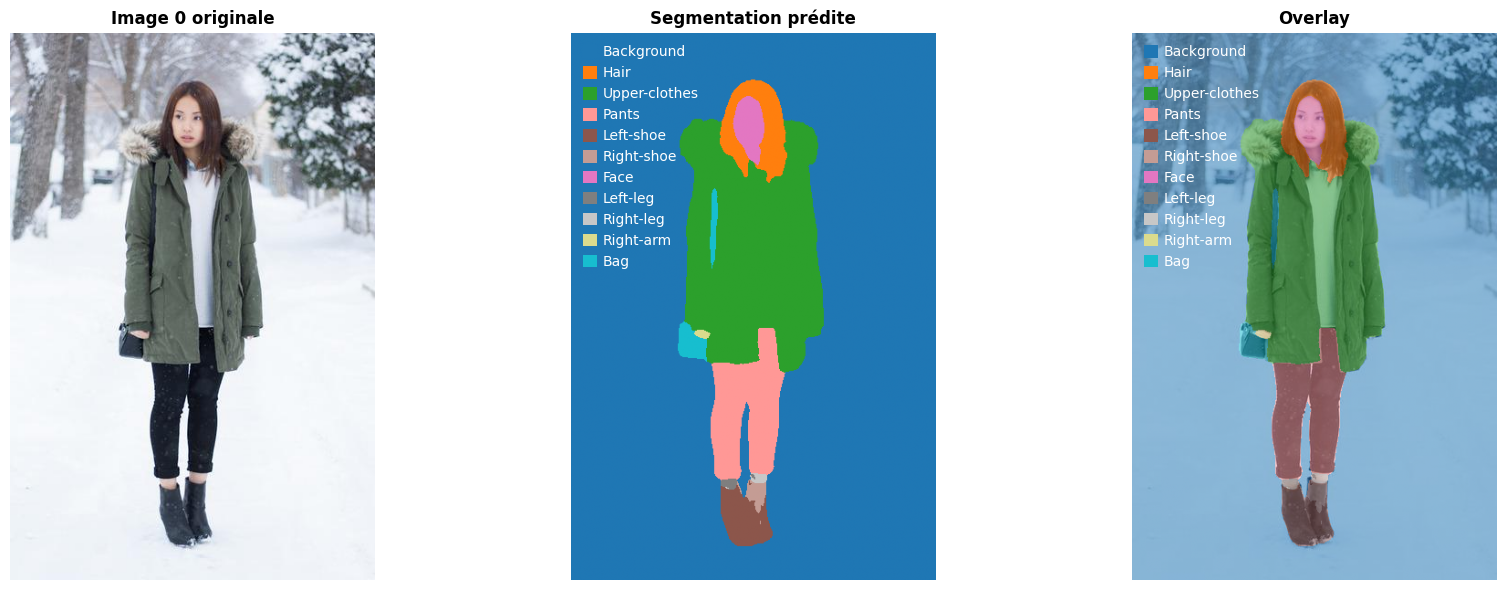


[2/2] Affichage de: content/images_a_segmenter/image_1.png


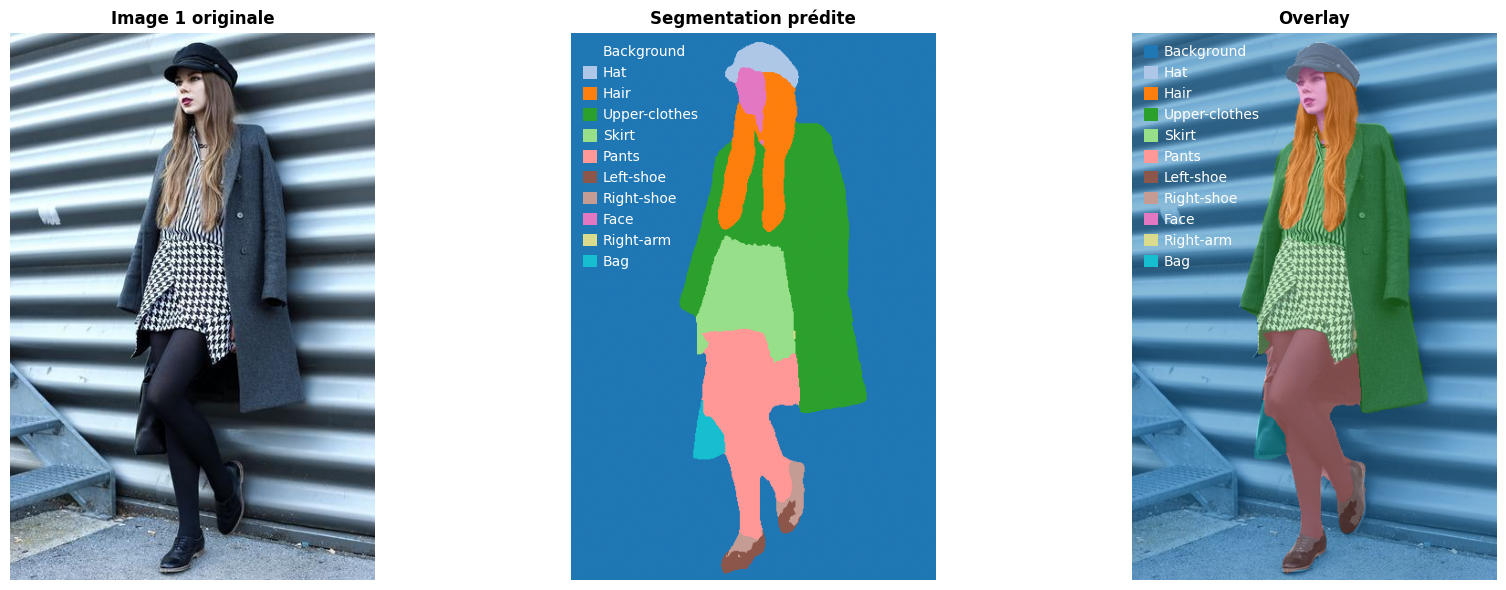


📊 RÉSUMÉ DE L'AFFICHAGE:
  • Total d'images: 2
  • Images affichées: 2
  • Erreurs: 0


In [ ]:
def display_segmented_images_batch(original_image_paths, segmentation_masks):
    """
    Affiche les images originales et leurs masques segmentés.

    Args:
        original_image_paths (list): Liste des chemins des images originales.
        segmentation_masks (list): Liste des masques segmentés (NumPy arrays).
    """
    if not original_image_paths or not segmentation_masks:
        print("Aucune image ou masque à afficher.")
        return

    if len(original_image_paths) != len(segmentation_masks):
        print(f"⚠️ Nombre d'images ({len(original_image_paths)}) différent du nombre de masques ({len(segmentation_masks)})")
        return

    # Configuration
    id_to_class = {v: k for k, v in CLASS_MAPPING.items()}
    color_map = plt.colormaps.get_cmap(COLORMAP_NAME).resampled(len(CLASS_MAPPING))
    num_classes = len(CLASS_MAPPING)

    stats = {
        'total': len(original_image_paths),
        'displayed': 0,
        'errors': 0
    }

    for idx, (img_path, mask_array) in enumerate(zip(original_image_paths, segmentation_masks), 1):
        print(f"\n[{idx}/{stats['total']}] Affichage de: {img_path}")

        try:
            # Charger l'image originale
            original_image = Image.open(img_path)

            # Extraire le numéro de l'image pour le titre
            filename = Path(img_path).name
            parts = filename.split(IMAGE_FILENAME_SEPARATOR)
            image_number = parts[IMAGE_NUMBER_INDEX].split('.')[0] if len(parts) > IMAGE_NUMBER_INDEX else str(idx)

            # Créer la figure avec 3 subplots
            fig, axes = plt.subplots(1, 3, figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

            # 1. Image originale
            axes[0].imshow(original_image)
            axes[0].set_title(f"Image {image_number} originale", fontsize=12, fontweight='bold')
            axes[0].axis("off")

            # 2. Masque de segmentation
            axes[1].imshow(
                mask_array,
                cmap=color_map,
                vmin=0,
                vmax=num_classes - 1
            )
            axes[1].set_title("Segmentation prédite", fontsize=12, fontweight='bold')
            axes[1].axis("off")

            # 3. Overlay (image + masque transparent)
            axes[2].imshow(original_image)
            axes[2].imshow(
                mask_array,
                cmap=color_map,
                alpha=OVERLAY_ALPHA,
                vmin=0,
                vmax=num_classes - 1
            )
            axes[2].set_title("Overlay", fontsize=12, fontweight='bold')
            axes[2].axis("off")

            # Ajouter les légendes
            legend_elements = get_legend_elements(mask_array, id_to_class, color_map, num_classes)
            axes[1].legend(handles=legend_elements, **LEGEND_CONFIG)
            axes[2].legend(handles=legend_elements, **LEGEND_CONFIG)

            plt.tight_layout()
            plt.show()

            stats['displayed'] += 1

        except Exception as e:
            print(f"❌ Erreur lors de l'affichage: {type(e).__name__}: {e}")
            stats['errors'] += 1

    # Résumé final
    print(f"\n{'='*60}")
    print(f"📊 RÉSUMÉ DE L'AFFICHAGE:")
    print(f"  • Total d'images: {stats['total']}")
    print(f"  • Images affichées: {stats['displayed']}")
    print(f"  • Erreurs: {stats['errors']}")
    print(f"{'='*60}")

# Afficher les résultats du batch
if batch_seg_results:
    display_segmented_images_batch(image_paths, batch_seg_results)
else:
    print("Aucun résultat de segmentation à afficher.")